In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

# 1. Cats and Dogs CNN Project

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [3]:
with zipfile.ZipFile("content/cats_and_dogs_filtered.zip", "r") as target_file:
    target_file.extractall("content/")

In [4]:
##### 데이터 갯수 확인

cats_train_list = os.listdir("content/cats_and_dogs_filtered/train/cats")
dogs_train_list = os.listdir("content/cats_and_dogs_filtered/train/dogs")

cats_val_list = os.listdir("content/cats_and_dogs_filtered/validation/cats")
dogs_val_list = os.listdir("content/cats_and_dogs_filtered/validation/dogs")

print(len(cats_train_list), len(dogs_train_list))
print(len(cats_val_list), len(dogs_val_list))

1000 1000
500 500


### train디렉토리에서 X_train, y_train 생성

In [5]:
image_list = []
label_list = []

train_base_dir = "content/cats_and_dogs_filtered/train"
train_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for train_label_name in train_label_list:
    if train_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(train_base_dir, train_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(224, 224))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)


걸린시간 :  0:00:08.480585


In [6]:
X_train = np.array(image_list).astype("float32")
y_train = np.array(label_list).astype("float32")

In [7]:
print(X_train.shape, y_train.shape)

(2000, 224, 224, 3) (2000,)


### validation디렉토리에서 X_val, y_val 생성

In [8]:
image_list = []
label_list = []


val_base_dir = "content/cats_and_dogs_filtered/validation"
val_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for val_label_name in val_label_list:
    if val_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(val_base_dir, val_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(224, 224))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)


걸린시간 :  0:00:05.073131


In [9]:
X_val = np.array(image_list).astype("float32")
y_val = np.array(label_list).astype("float32")

In [11]:
print(X_val.shape, y_val.shape)

(1000, 224, 224, 3) (1000,)


### validation으로부터 test data 분리( 분리 비율은 5 : 5)

In [12]:
s = np.arange(len(X_val))
np.random.shuffle(s)

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.5 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

In [13]:
print(X_val.shape, X_test.shape)
print(y_val.shape, y_test.shape)

(500, 224, 224, 3) (500, 224, 224, 3)
(500,) (500,)


### 이미지 데이터 정규화

In [14]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### CNN 모델 구축

- C C P(32)   C C P(64)   C P(128)   C P(128)   C P(256)   F D D

In [18]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='SAME', 
                 input_shape=(224,224,3))) 
model.add(Conv2D(32, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='SAME'))
model.add(Conv2D(64, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [19]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

In [ ]:
start_time = datetime.now()

result = model.fit(X_train, y_train,
                 epochs=30, batch_size=16, 
                 validation_data=(X_val, y_val))

end_time = datetime.now()


In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

# 2. 전이 학습의 개요
- [ImageNet](https://papaercode/data/imagenet)처럼 아주 큰 데이터셋을 사용하여 사전 학습 모델(pre-trained model)의 가중치를 가져와
    우리가 분석하려는 데이터에 맞게 보정해서 사용하는 것을 의미
- 사전 학습 모델은 특징 추출기와 분류기로 이루어져있다
- 이미 만들어진 모델의 특징만 사용해서 fine tunning. 분류기는 따로 제작
- Inception v3(알파고), ResNet(MS), Xception, MobileNet
- pip install tensorflow-hub

In [2]:
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet

In [ ]:
# !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

with zipfile.ZipFile("/content/cats_and_dogs_filtered.zip", "r") as target_file:
    target_file.extractall("content/")

##### 데이터 갯수 확인

cats_train_list = os.listdir("content/cats_and_dogs_filtered/train/cats")
dogs_train_list = os.listdir("content/cats_and_dogs_filtered/train/dogs")

cats_val_list = os.listdir("content/cats_and_dogs_filtered/validation/cats")
dogs_val_list = os.listdir("content/cats_and_dogs_filtered/validation/dogs")

print(len(cats_train_list), len(dogs_train_list))
print(len(cats_val_list), len(dogs_val_list))

### train디렉토리에서 X_train, y_train 생성

image_list = []
label_list = []


train_base_dir = "content/cats_and_dogs_filtered/train"
train_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for train_label_name in train_label_list:
    if train_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(train_base_dir, train_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(224, 224))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_train = np.array(image_list).astype("float32")
y_train = np.array(label_list).astype("float32")

print(X_train.shape, y_train.shape)

### validation디렉토리에서 X_val, y_val 생성

image_list = []
label_list = []


val_base_dir = "content/cats_and_dogs_filtered/validation"
val_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for val_label_name in val_label_list:
    if val_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(val_base_dir, val_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(224, 224))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_val = np.array(image_list).astype("float32")
y_val = np.array(label_list).astype("float32")

print(X_val.shape, y_val.shape)

### validation으로부터 test data 분리( 분리 비율은 5 : 5)

s = np.arange(len(X_val))
np.random.shuffle(s)

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.5 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

print(X_val.shape, X_test.shape)
print(y_val.shape, y_test.shape)

### 이미지 데이터 정규화

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### CNN 모델 구축

- C C P(32)   C C P(64)   C P(128)   C P(128)   C P(256)   F D D

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='SAME', 
                 input_shape=(224,224,3))) 
model.add(Conv2D(32, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='SAME'))
model.add(Conv2D(64, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu', padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

start_time = datetime.now()

result = model.fit(X_train, y_train,
                 epochs=20, batch_size=16, 
                 validation_data=(X_val, y_val))

end_time = datetime.now()


model.evaluate(X_test, y_test)


### 전이학습 모델 MobileNet 이용
from tensorflow.keras.applications import Xception, ResNet50, MobileNet

base_model= MobileNet(weights='imagenet', include_top=True, input_shape=(224,224,3))
base_model.summary()

base_model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

start_time = datetime.now()

result = base_model.fit(X_train, y_train,
                 epochs=30, batch_size=16, 
                 validation_data=(X_val, y_val))

end_time = datetime.now()

model.evaluate(X_test, y_test)

### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

# 3. Fine Tunning
- include top에서 결정됨
- include top=False면 내가 직접 분류기 생성
- learning rate가 가장 중요! 기본값보다는 작게 설정. 최대 2e-5까지 줄여보기

In [2]:
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet

1000 1000
500 500

걸린시간 :  0:00:26.804477
(2000, 224, 224, 3) (2000,)

걸린시간 :  0:00:12.980988
(1000, 224, 224, 3) (1000,)
(500, 224, 224, 3) (500, 224, 224, 3)
(500,) (500,)
17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 16)                802832    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense

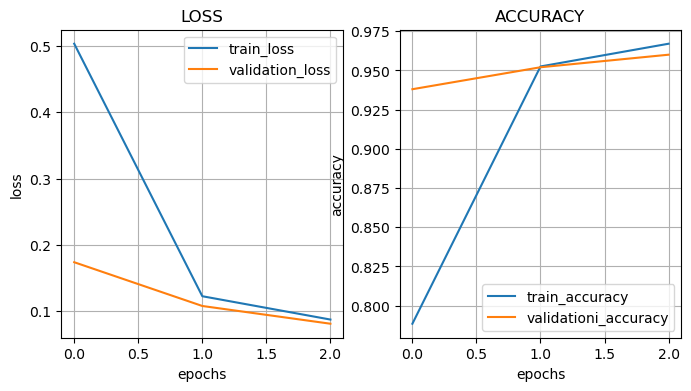

In [5]:
# !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

# with zipfile.ZipFile("content/cats_and_dogs_filtered.zip", "r") as target_file:
#     target_file.extractall("content/")

##### 데이터 갯수 확인

cats_train_list = os.listdir("ㄴ")
dogs_train_list = os.listdir("content/cats_and_dogs_filtered/train/dogs")

cats_val_list = os.listdir("content/cats_and_dogs_filtered/validation/cats")
dogs_val_list = os.listdir("content/cats_and_dogs_filtered/validation/dogs")

print(len(cats_train_list), len(dogs_train_list))
print(len(cats_val_list), len(dogs_val_list))

IMAGE_WIDTH= 224
IMAGE_HEIGHT= 224

### train디렉토리에서 X_train, y_train 생성

image_list = []
label_list = []


train_base_dir = "content/cats_and_dogs_filtered/train"
train_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for train_label_name in train_label_list:
    if train_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(train_base_dir, train_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(IMAGE_WIDTH,IMAGE_HEIGHT))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_train = np.array(image_list).astype("float32")
y_train = np.array(label_list).astype("float32")

print(X_train.shape, y_train.shape)

### validation디렉토리에서 X_val, y_val 생성

image_list = []
label_list = []


val_base_dir = "content/cats_and_dogs_filtered/validation"
val_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for val_label_name in val_label_list:
    if val_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(val_base_dir, val_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(IMAGE_WIDTH,IMAGE_HEIGHT))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_val = np.array(image_list).astype("float32")
y_val = np.array(label_list).astype("float32")

print(X_val.shape, y_val.shape)

### validation으로부터 test data 분리( 분리 비율은 5 : 5)

s = np.arange(len(X_val))
np.random.shuffle(s)

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.5 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

print(X_val.shape, X_test.shape)
print(y_val.shape, y_test.shape)

### 이미지 데이터 정규화

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# ### CNN 모델 구축

# - C C P(32)   C C P(64)   C P(128)   C P(128)   C P(256)   F D D

# model = Sequential()

# model.add(Conv2D(32, (3,3), activation='relu', padding='SAME', 
#                  input_shape=(224,224,3))) 
# model.add(Conv2D(32, (3,3), activation='relu', padding='SAME'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3,3), activation='relu', padding='SAME'))
# model.add(Conv2D(64, (3,3), activation='relu', padding='SAME'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3,3), activation='relu', padding='SAME'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3,3), activation='relu', padding='SAME'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3,3), activation='relu', padding='SAME'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(GlobalAveragePooling2D())

# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(2, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

# start_time = datetime.now()

# result = model.fit(X_train, y_train,
#                  epochs=20, batch_size=16, 
#                  validation_data=(X_val, y_val))

# end_time = datetime.now()


# model.evaluate(X_test, y_test)


### 전이학습 모델 MobileNet 이용
from tensorflow.keras.applications import Xception, ResNet50, MobileNet, InceptionV3

base_model= MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
# base_model.summary()

# base_model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['acc'])

model= Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

# model.add(Dense(1, activation='sigmoid')) # 이진분류. binary_crossentropy
model.add(Dense(2, activation='softmax')) # 다중분류


model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), metrics=['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(X_train, y_train,
                 epochs=3, batch_size=32, 
                 validation_data=(X_val, y_val))

end_time = datetime.now()

model.evaluate(X_test, y_test)

### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

predictions (Activation)    (None, 1000)              0         
     -> 분류기 사용한 결과. include_top= True
     
     
mixed10 (Concatenate)          (None, 5, 5, 2048)   0  
    -> 분류기 직접 생성. include_top=False